In [1]:
import pandas as pd
import torch
from chronos import BaseChronosPipeline
import tqdm as notebook_tqdm

import numpy as np
import pandas as pd

import Utils 
from Utils import calculateEMA, calculateBB, addPreviousDays, removeColumns, getPeriod, mape, mae, createDate, getDate, printResult

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')
import pdb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

c:\Users\Rodrigo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def getPredictDf(fundo):
    pred = pd.read_pickle(f'../Data/Joao_Data/{fundo}_Pred_with_confidence_and_valid_.pkl')
    return pred

In [3]:
getPredictDf('ABEV3')

,date,high_pred,low_pred,uncertainty_high,uncertainty_low,uncertainty_mean,uncertainty_valid_mean,high,low
948,2021.04.06,14.929067,14.496667,0.174107,0.145275,0.159691,0.157846,14.97,14.66
949,2021.04.07,14.915267,14.491467,0.160525,0.149532,0.155029,0.172113,14.92,14.59
950,2021.04.08,14.979367,14.506133,0.173733,0.136840,0.155286,0.195083,15.15,14.64
951,2021.04.09,15.094700,14.600000,0.174315,0.167907,0.171111,0.194198,15.12,14.71
952,2021.04.12,15.174000,14.783700,0.116588,0.153608,0.135098,0.120745,15.08,14.85
953,2021.04.13,15.196700,14.815733,0.104668,0.109534,0.107101,0.110236,15.22,14.86
954,2021.04.14,15.341533,14.920333,0.140008,0.132348,0.136178,0.153039,15.37,15.10
955,2021.04.15,15.419800,15.043833,0.117802,0.120096,0.118949,0.182800,15.50,15.20
956,2021.04.16,15.423533,15.043733,0.129785,0.116296,0.123041,0.163664,15.43,15.20
957,2021.04.19,15.323067,14.914800,0.206885,0.169029,0.187957,0.176248,15.54,15.00


In [5]:
def generatePlot(y_test_orig, y_pred_mean, uncertainty, target_col, fundo): 
    # Criar eixo de tempo
    dias = np.arange(len(y_test_orig))

    # Calcular faixa de incerteza (intervalo 90% - 10%)
    inferior = y_pred_mean - (uncertainty / 2)
    superior = y_pred_mean + (uncertainty / 2)

    plt.figure(figsize=(10, 6))

    # Linha real (azul)
    plt.plot(dias, y_test_orig, label='Valor Real', color='blue', marker='o')

    # Linha prevista (laranja)
    plt.plot(dias, y_pred_mean, label='Previsão Média', color='red', marker='o')

    # Faixa de incerteza (sombreada)
    plt.fill_between(dias, inferior, superior, color='orange', alpha=0.3, label='Incerteza')

    # Rótulos e legendas
    plt.title(f'Previsão com Random Forest vs Valor Real {fundo}')
    plt.xlabel('Dias')
    plt.ylabel('Preço (' + target_col + ')')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


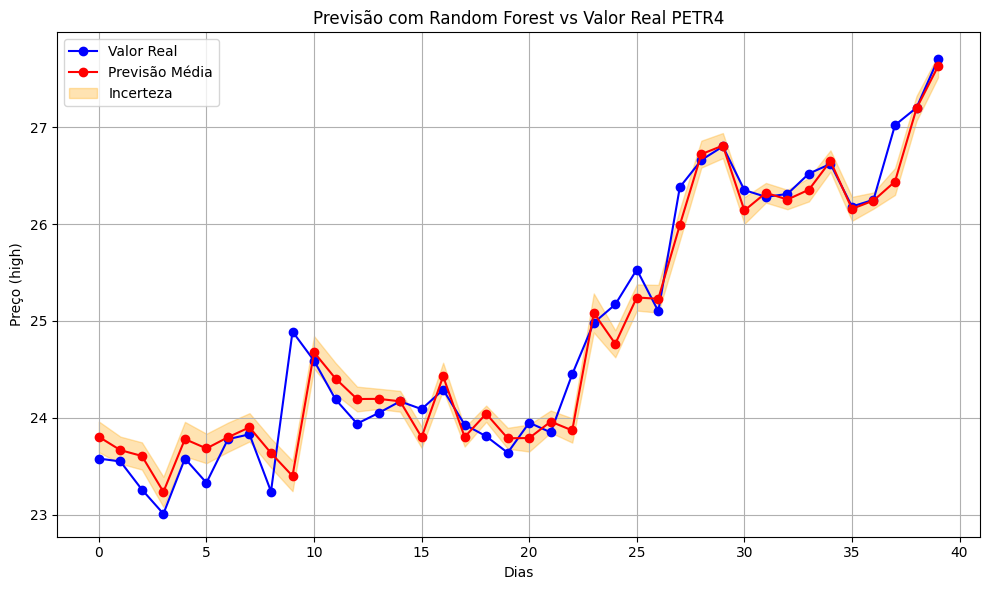

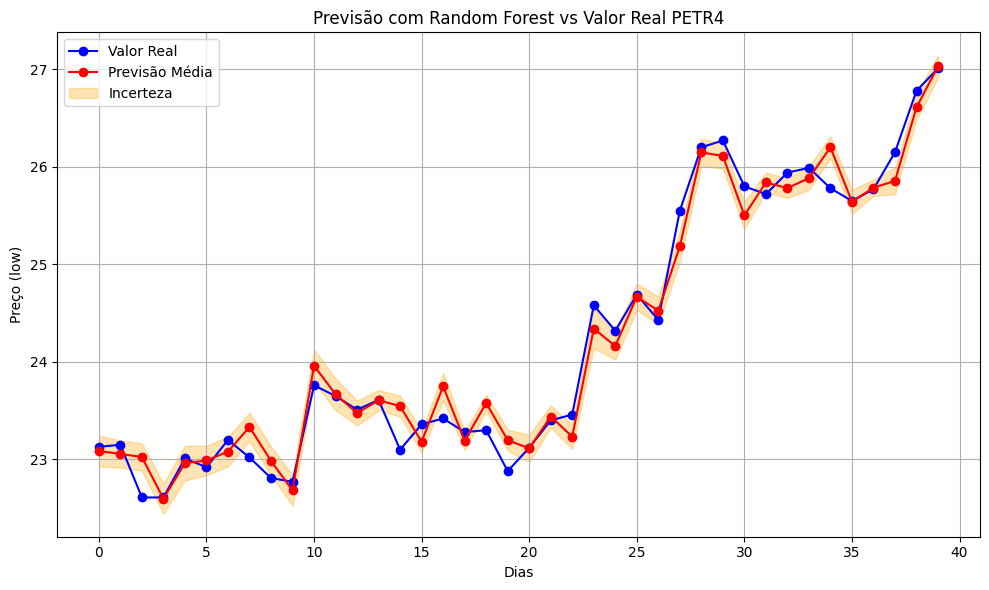

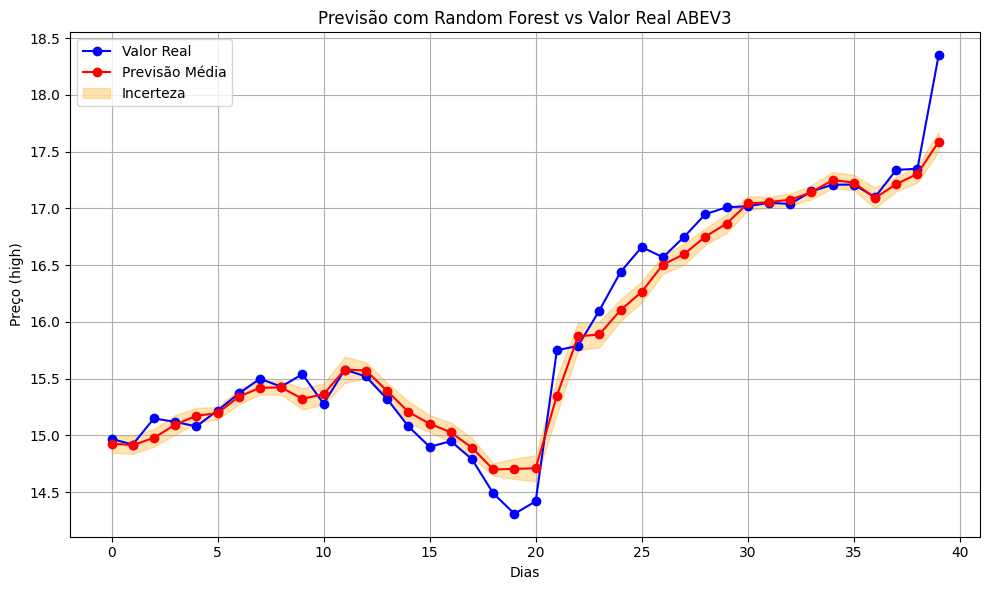

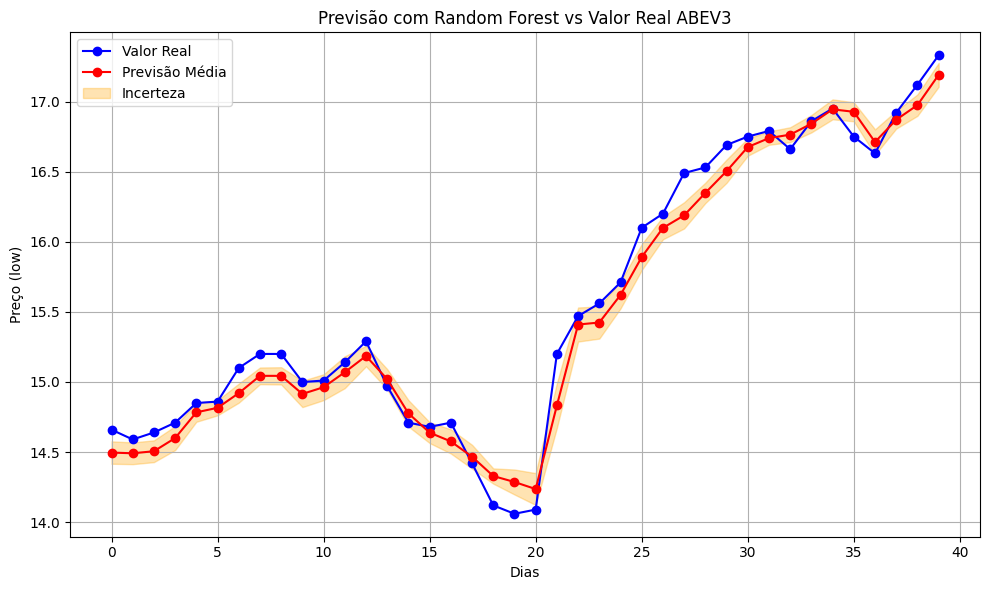

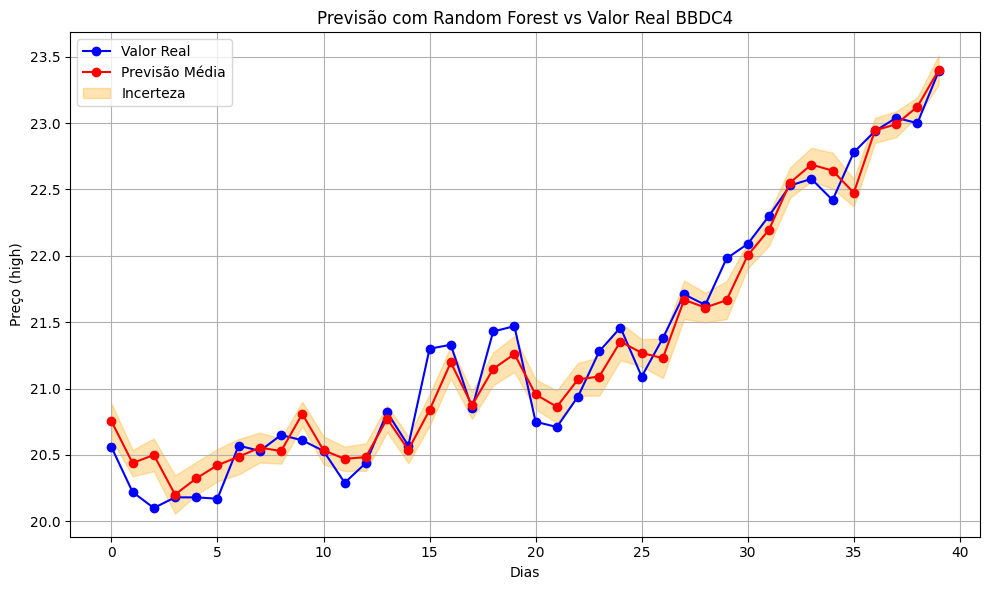

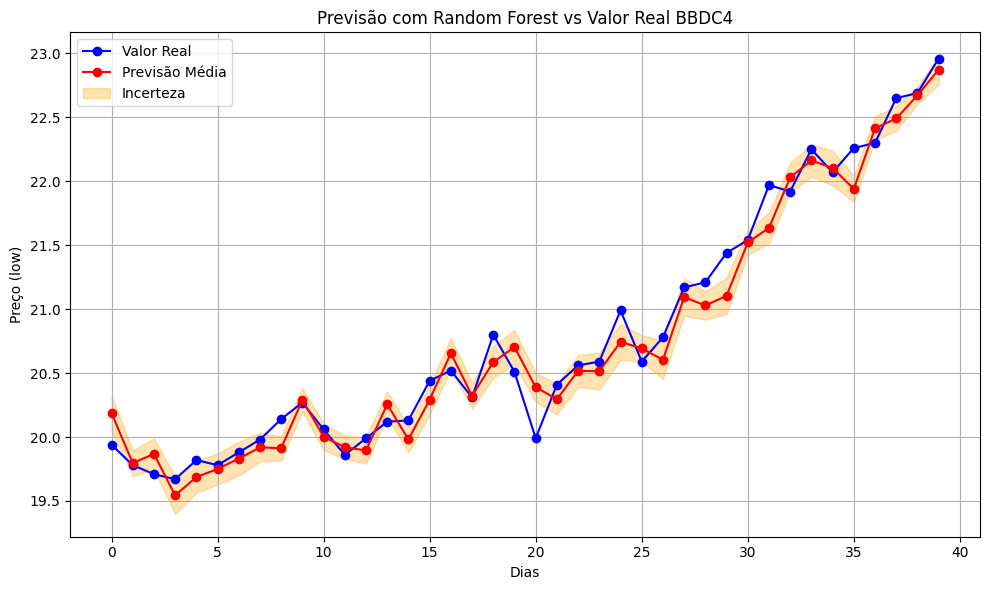

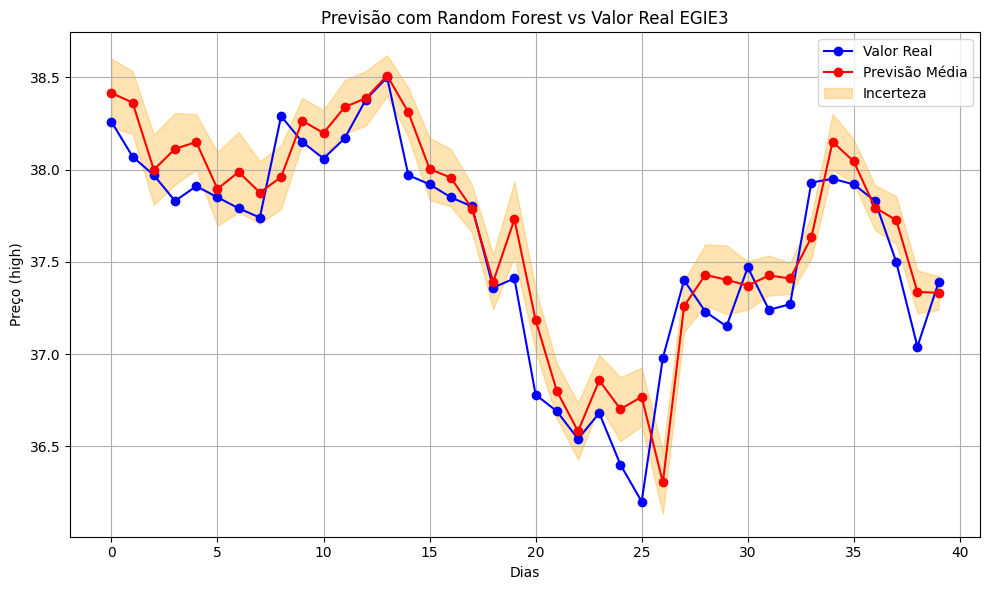

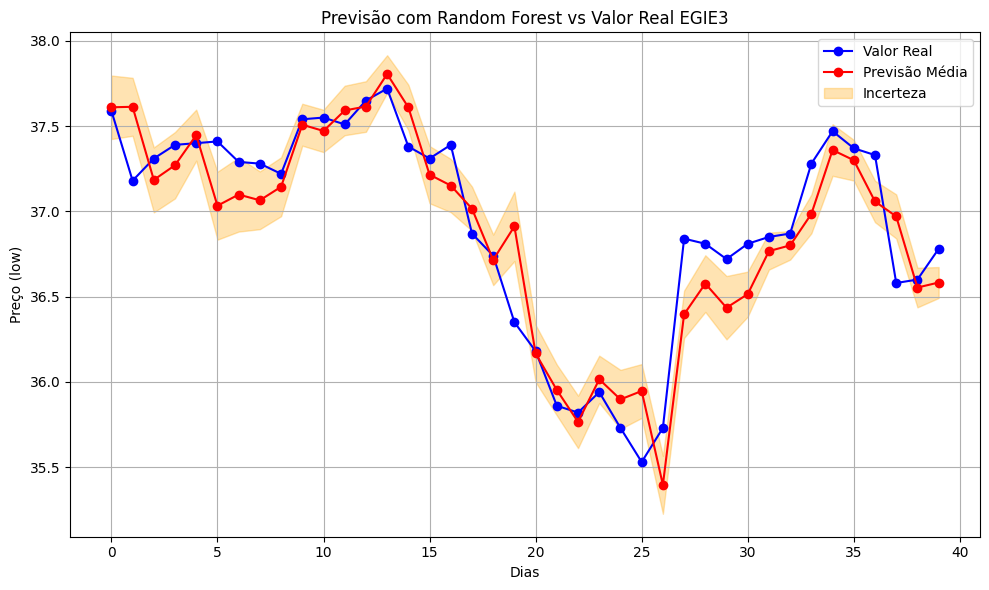

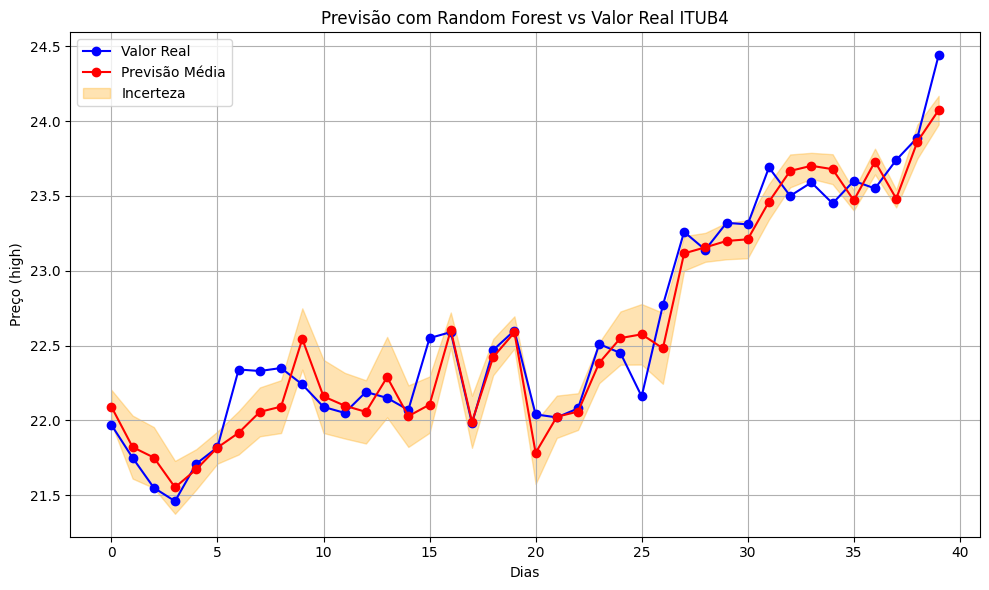

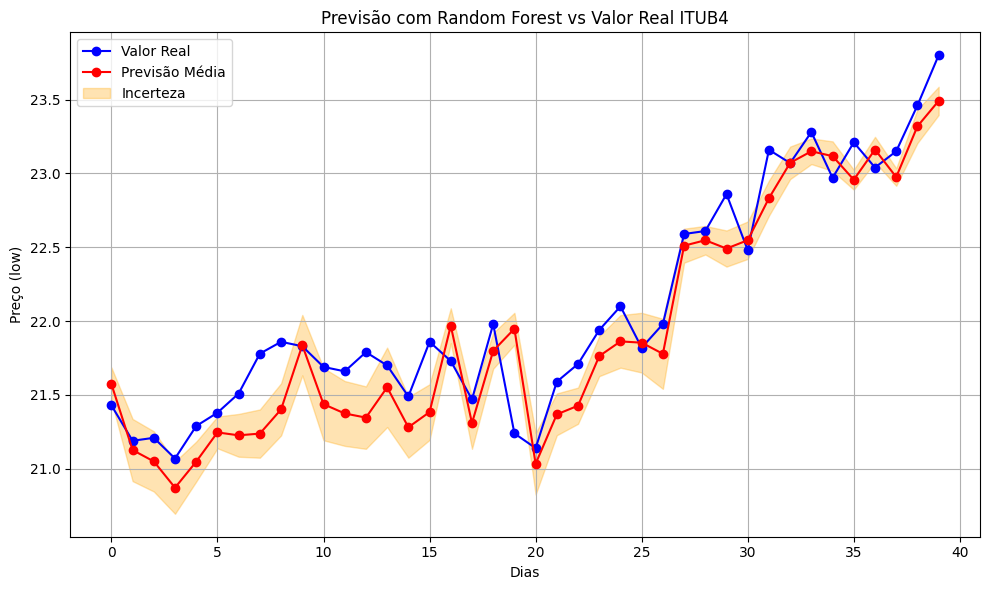

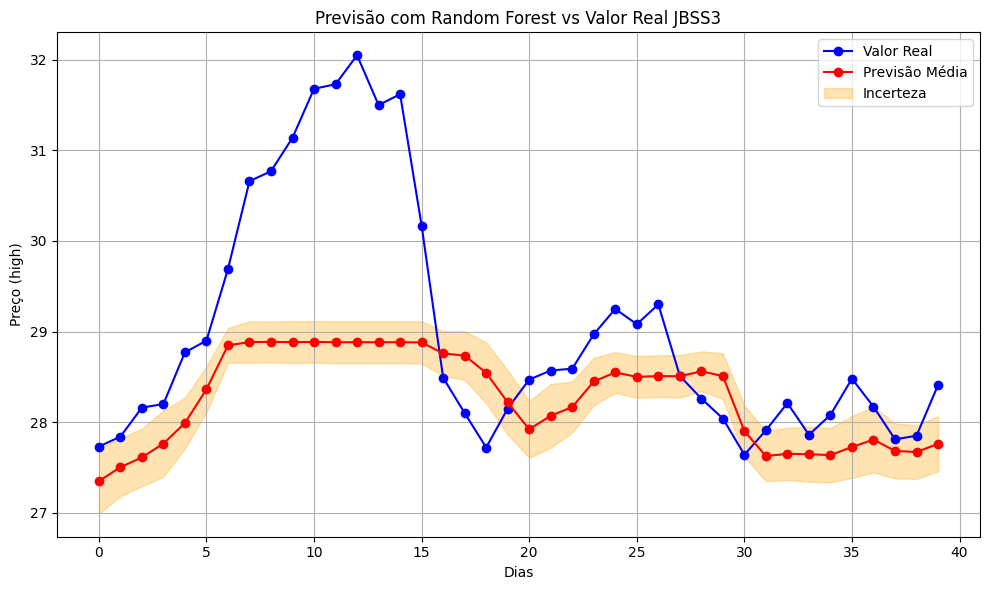

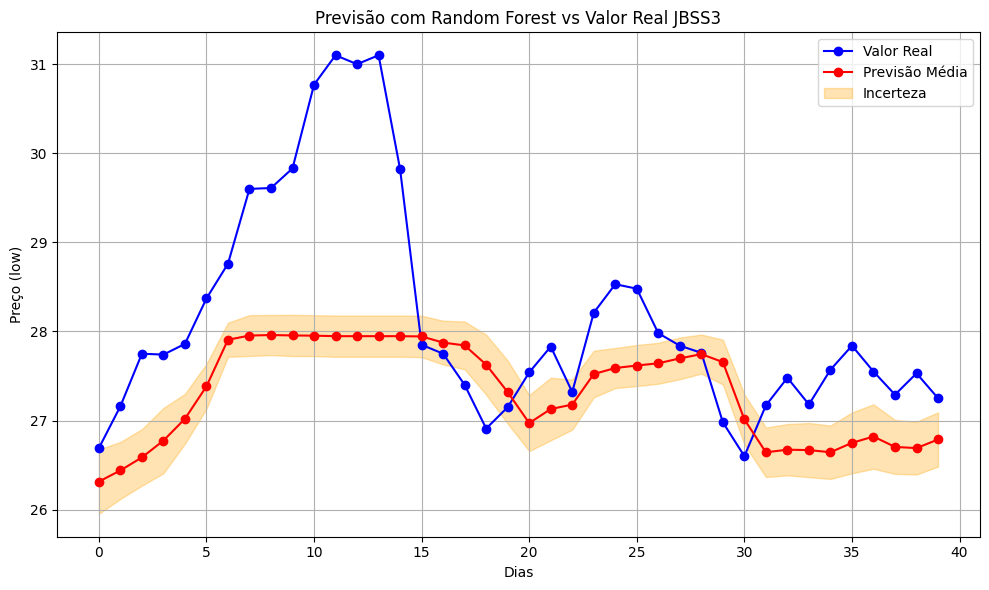

In [6]:
fundos = ['PETR4', 'ABEV3', 'BBDC4', 'EGIE3', 'ITUB4', 'JBSS3']
for name in fundos:
    df = getPredictDf(name)
    generatePlot(df['high'], df['high_pred'], df['uncertainty_mean'], 'high', name)
    generatePlot(df['low'], df['low_pred'], df['uncertainty_mean'], 'low', name)
   